<td>
   <a target="_blank" href="https://labelbox.com" ><img src="https://labelbox.com/blog/content/images/2021/02/logo-v4.svg" width=256/></a>
</td>

<td>
<a href="https://colab.research.google.com/github/Labelbox/labelbox-python/blob/develop/examples/label_export/video.ipynb" target="_blank"><img
src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</td>

<td>
<a href="https://github.com/Labelbox/labelbox-python/tree/develop/examples/label_export/video.ipynb" target="_blank"><img
src="https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white" alt="GitHub"></a>
</td>

# Video Data Export
* Export labels from video annotation projects

In [1]:
!pip install labelbox
!pip install requests
!pip install numpy
!pip install PILLOW
!pip install matplotlib
!pip install ndjson
!pip install ipython
!pip install opencv-python

In [2]:
from labelbox import Client
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
from getpass import getpass
import ndjson
import requests
import cv2
from collections import Counter
from typing import Dict, Any
import os

In [3]:
# If you don't want to give google access to drive you can skip this cell
# and manually set `API_KEY` below.

COLAB = "google.colab" in str(get_ipython())
if COLAB:
    !pip install colab-env -qU
    from colab_env import envvar_handler
    envvar_handler.envload()

API_KEY = os.environ.get("LABELBOX_API_KEY")
if not os.environ.get("LABELBOX_API_KEY"):
    API_KEY = getpass("Please enter your labelbox api key")
    if COLAB:
        envvar_handler.add_env("LABELBOX_API_KEY", API_KEY)

In [4]:
# Pick a video project with completed bounding box labels
PROJECT_ID = "ckqcx1d58068c0y619qv7hzgu"
# Only update this if you have an on-prem deployment
ENDPOINT = "https://api.labelbox.com/graphql"

In [5]:
client = Client(api_key=API_KEY, endpoint=ENDPOINT)
project = client.get_project(PROJECT_ID)

### Export the labels

In [6]:
export_url = project.export_labels()

In [7]:
print(export_url)

https://storage.googleapis.com/labelbox-exports/ckqcx1czn06830y61gh9v02cs/ckqcx1d58068c0y619qv7hzgu/export-2021-07-12T06%3A09%3A49.855Z.json?GoogleAccessId=api-prod%40labelbox-193903.iam.gserviceaccount.com&Expires=1627279880&Signature=ehFSQH0BRl%2FNSA2CWf3pWzNxmWLmSnl7AKWo8mdLwLjcYWotziyeEyALA3Y1ev29lE56ovj0eo5g%2B22MyHxc4t%2FDDPLIMGhEFKLrK2bKBHtfCeVmgDkM%2BwgUAAKeW2pne9zMoD%2FIi9xS4DkfRO4EvHC2KEQRj61Q6kum4HnHZpWt2G7FCQ4GgqS2mSd6TMkWb6ln091f5qJpbpo%2Bjwg8v1Fkcald%2Bxt3P0bLrpXj5ZTb3PTR6zEjfk9JXtq%2Fe7sE%2FXFfjPBIgSphVo1vLCcfkjnAvt7rrqpRgq6Mj%2FZzfCAu2IgIHPmsxCm4ebyAKQ4OfbcRzCOEFeclyYymUVPS3w%3D%3D&response-content-disposition=attachment


In [8]:
exports = requests.get(export_url).json()

* To get more information on the fields in the label payload click on the following link: https://docs.labelbox.com/data-model/en/index-en#label

In [9]:
# One export for each data_row (video)
exports[0]

{'ID': 'ckqcx1dae06ez0y61e7dsh65i',
 'DataRow ID': 'ckqcx1d6f06c70y61dcap7u95',
 'Labeled Data': 'https://storage.labelbox.com/cjhfn5y6s0pk507024nz1ocys%2Fb8837f3b-b071-98d9-645e-2e2c0302393b-jellyfish2-100-110.mp4?Expires=1627279789894&KeyName=labelbox-assets-key-3&Signature=Z-4fGzE9VlnKInZv_aLun9IxrJM',
 'Label': {'frames': 'https://api.labelbox.com/v1/frames/ckqcx1dae06ez0y61e7dsh65i'},
 'Created By': 'msokoloff+11@labelbox.com',
 'Project Name': 'Sample Video Project',
 'Created At': '2021-06-25T22:38:27.000Z',
 'Updated At': '2021-06-25T22:38:27.997Z',
 'Seconds to Label': 15.206,
 'External ID': 'jellyfish2-100-110.mp4',
 'Agreement': -1,
 'Benchmark Agreement': -1,
 'Benchmark ID': None,
 'Dataset Name': 'Example Jellyfish Dataset',
 'Reviews': [],
 'View Label': 'https://editor.labelbox.com?project=ckqcx1d58068c0y619qv7hzgu&label=ckqcx1dae06ez0y61e7dsh65i',
 'Has Open Issues': 0,
 'Skipped': False}

### Using the data
* Each frame's label must be fetched individually.

In [10]:
video_url = exports[0]["Labeled Data"]
annotations_url = exports[0]["Label"]["frames"]
# View the video in your browser by clicking on the link
print(video_url)

https://storage.labelbox.com/cjhfn5y6s0pk507024nz1ocys%2Fb8837f3b-b071-98d9-645e-2e2c0302393b-jellyfish2-100-110.mp4?Expires=1627279789894&KeyName=labelbox-assets-key-3&Signature=Z-4fGzE9VlnKInZv_aLun9IxrJM


In [11]:
with open("/tmp/sample_video.mp4", "wb") as file:
    file.write(requests.get(video_url).content)

#### Turn video into individual frames

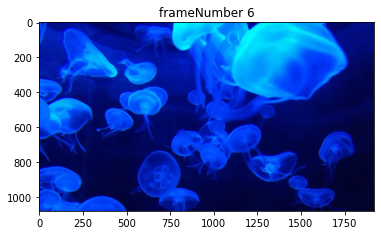

In [12]:
vidcap = cv2.VideoCapture("/tmp/sample_video.mp4")
success, image = vidcap.read()
image = image[:, :, ::-1]
# Note that frameNumber 1 in the annotation is frame index 0s
count = 1
while success and count < 20:
    plt.figure(1)
    plt.imshow(image)
    plt.title('frameNumber ' + str(count))
    plt.pause(0.25)
    plt.clf()
    success, image = vidcap.read()
    count += 1
    if success and count < 20:
        clear_output(wait=True)
    image = image[:, :, ::-1]

In [13]:
headers = {"Authorization": f"Bearer {API_KEY}"}
annotations = ndjson.loads(requests.get(annotations_url, headers=headers).text)
# Make it easy to lookup
annotations = {annot["frameNumber"]: annot for annot in annotations}
print(annotations[1])

In [14]:
def visualize_bbox(image: np.ndarray, tool: Dict[str, Any]) -> np.ndarray:
    """
    Draws a bounding box on an image
    
    Args:
        image (np.ndarray): image to draw a bounding box onto
        tool (Dict[str,any]): Dict response from the export
    Returns:
        image with a bounding box drawn on it.
    """
    start = (int(tool["bbox"]["left"]), int(tool["bbox"]["top"]))
    end = (int(tool["bbox"]["left"] + tool["bbox"]["width"]),
           int(tool["bbox"]["top"] + tool["bbox"]["height"]))
    return cv2.rectangle(image, start, end, (255, 0, 0), 5)

#### Visualize annotations overlaid onto individual frames

In [15]:
vidcap = cv2.VideoCapture('/tmp/sample_video.mp4')
success, image = vidcap.read()
image = image[:, :, ::-1]
# Note that frameNumber 1 in the annotation is frame index 0
count = 1

while success and count < 20:
    annotation = annotations.get(count)
    if annotation is not None:
        for tool in annotation['objects']:
            if 'bbox' in tool:
                image = visualize_bbox(image.astype(np.uint8), tool)
    plt.figure(1)
    plt.imshow(image)
    plt.title('frameNumber ' + str(count))
    plt.pause(0.25)
    plt.clf()

    success, image = vidcap.read()
    count += 1
    if success and count < 20:
        clear_output(wait=True)
    image = image[:, :, ::-1]